# **Model Implementation from scratch for U-NET with EfficientNet-0**

In [ ]:
!pip install segmentation-models-pytorch efficientnet-pytorch albumentations==1.3.1 --quiet
!pip install segmentation_models_pytorch --quiet
!pip install roboflow
!pip install opencv-python

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, jaccard_score

import segmentation_models_pytorch as smp
from roboflow import Roboflow
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
rf = Roboflow(api_key="fHjvN0Omsz5XAduuX3xI")
project = rf.workspace("pothole-detection-fi0rt").project("pothole-semantic-segmentation")
version = project.version(1)
dataset = version.download("png-mask-semantic")
dataset_dir = dataset.location

#Cleaning and Spliting the dataset
image_dir = 'Pothole-Semantic-Segmentation-1/train'

all_files = os.listdir(image_dir)

images = sorted([f for f in all_files if f.endswith('.jpg')])
masks = sorted([f for f in all_files if f.endswith('.png')])

print(f"Total images: {len(images)}")
print(f"Total masks: {len(masks)}")

mask_dict = {}
for mask in masks:
    base = os.path.splitext(mask)[0]
    if base.endswith('_mask'):
        base = base[:-5]
    mask_dict[base] = mask

matched_pairs = []
for img in images:
    base = os.path.splitext(img)[0]
    if base in mask_dict:
        matched_pairs.append((img, mask_dict[base]))

print(f"Total matched image-mask pairs: {len(matched_pairs)}")

train_val_pairs, test_pairs = train_test_split(matched_pairs, test_size=0.1, random_state=42)
train_pairs, val_pairs = train_test_split(train_val_pairs, test_size=0.1111, random_state=42)

print(f"Train pairs: {len(train_pairs)}")
print(f"Validation pairs: {len(val_pairs)}")
print(f"Test pairs: {len(test_pairs)}")

def create_split(split_name, pairs):
    os.makedirs(f'dataset/{split_name}/images', exist_ok=True)
    os.makedirs(f'dataset/{split_name}/masks', exist_ok=True)
    for img_name, mask_name in pairs:
        shutil.copy(os.path.join(image_dir, img_name), f'dataset/{split_name}/images/{img_name}')
        shutil.copy(os.path.join(image_dir, mask_name), f'dataset/{split_name}/masks/{mask_name}')

create_split('train', train_pairs)
create_split('val', val_pairs)
create_split('test', test_pairs)


loading Roboflow workspace...
loading Roboflow project...
Total images: 4268
Total masks: 4268
Total matched image-mask pairs: 4268
Train pairs: 3414
Validation pairs: 427
Test pairs: 427


# Initial Model

In [ ]:
#Images/Masks Load & Resize → Apply Transform (to image) → Convert Mask to Binary Tensor → Return (image, mask) as PyTorch tensors

class PotholeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = mask.resize((image.shape[2], image.shape[1]), resample=Image.NEAREST)
            mask = torch.from_numpy(np.array(mask)).long()
            mask = (mask > 0).float().unsqueeze(0)

        return image, mask


In [ ]:
#perform sequence of transformations - image→ converts it to a tensor → normalizes it to match model input
transform = transforms.Compose([
    transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


In [ ]:
data_root = 'dataset'

train_img_dir = os.path.join(data_root, 'train', 'images')
train_mask_dir = os.path.join(data_root, 'train', 'masks')

val_img_dir = os.path.join(data_root, 'val', 'images')
val_mask_dir = os.path.join(data_root, 'val', 'masks')

test_img_dir = os.path.join(data_root, 'test', 'images')
test_mask_dir = os.path.join(data_root, 'test', 'masks')

train_dataset = PotholeDataset(train_img_dir, train_mask_dir, transform=transform)
val_dataset = PotholeDataset(val_img_dir, val_mask_dir, transform=transform)
test_dataset = PotholeDataset(test_img_dir, test_mask_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = smp.Unet("efficientnet-b0", encoder_weights="imagenet", in_channels=3, classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


In [ ]:
def train_one_epoch(loader):
    model.train()
    epoch_loss = 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def validate(loader):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)


In [ ]:
train_losses = []
val_losses = []

num_epochs = 30
best_val_loss = float('inf')  # initialize with very large value

for epoch in range(num_epochs):
    train_loss = train_one_epoch(train_loader)
    val_loss = validate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "efficientnet-b0_unet_best_initial.pth")
        print(f"✅ Saved best model at epoch {epoch+1} with val loss: {val_loss:.4f}")

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 1/30 | Train Loss: 0.5264 | Val Loss: 0.2678
✅ Saved best model at epoch 1 with val loss: 0.2678
Epoch 2/30 | Train Loss: 0.2020 | Val Loss: 0.1337
✅ Saved best model at epoch 2 with val loss: 0.1337
Epoch 3/30 | Train Loss: 0.1266 | Val Loss: 0.1106
✅ Saved best model at epoch 3 with val loss: 0.1106
Epoch 4/30 | Train Loss: 0.1020 | Val Loss: 0.0977
✅ Saved best model at epoch 4 with val loss: 0.0977
Epoch 5/30 | Train Loss: 0.0865 | Val Loss: 0.0935
✅ Saved best model at epoch 5 with val loss: 0.0935
Epoch 6/30 | Train Loss: 0.0763 | Val Loss: 0.0925
✅ Saved best model at epoch 6 with val loss: 0.0925
Epoch 7/30 | Train Loss: 0.0676 | Val Loss: 0.0905
✅ Saved best model at epoch 7 with val loss: 0.0905
Epoch 8/30 | Train Loss: 0.0633 | Val Loss: 0.0916
Epoch 9/30 | Train Loss: 0.0589 | Val Loss: 0.0972
Epoch 10/30 | Train Loss: 0.0539 | Val Loss: 0.0899
✅ Saved best model at epoch 10 with val loss: 0.0899
Epoch 11/30 | Train Loss: 0.0499 | Val Loss: 0.0930
Epoch 12/30 | Train 

In [ ]:
model.load_state_dict(torch.load("efficientnet-b0_unet_best_initial.pth"))
model.eval()

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identit

In [ ]:
all_preds, all_targets = [], []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        outputs = torch.sigmoid(model(images)).cpu().squeeze().numpy()
        outputs = (outputs>0.3).astype(np.uint8)
        targets = masks.squeeze().numpy().astype(np.uint8)

        all_preds.append(outputs.flatten())
        all_targets.append(targets.flatten())

# Convert to arrays
y_true = np.concatenate(all_targets)
y_pred = np.concatenate(all_preds)

print("IoU:", jaccard_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))


IoU: 0.7210845937962436
Precision: 0.8166160323568583
Recall: 0.8604118416019705
F1 Score: 0.8379420702450511


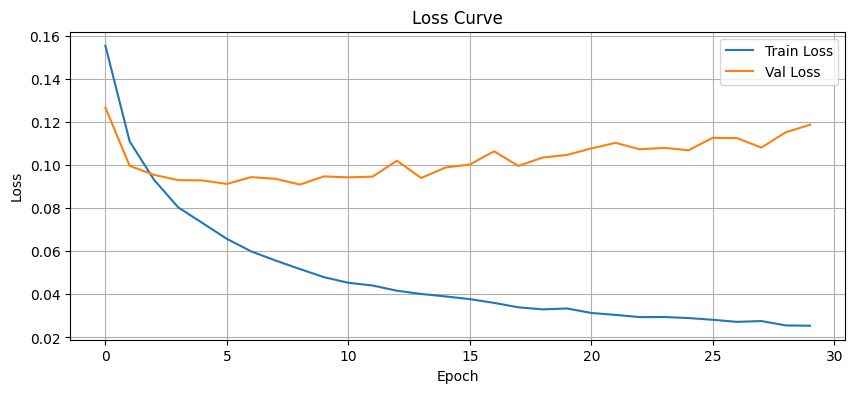

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# efficientnet-b0_unet_best_1.pth

In [ ]:
class PotholeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))

        mask = (mask > 0).astype(np.float32)  # Convert to binary

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)  # Add channel dim

        return image, mask


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [ ]:
data_root = 'dataset'

train_img_dir = os.path.join(data_root, 'train', 'images')
train_mask_dir = os.path.join(data_root, 'train', 'masks')

val_img_dir = os.path.join(data_root, 'val', 'images')
val_mask_dir = os.path.join(data_root, 'val', 'masks')

test_img_dir = os.path.join(data_root, 'test', 'images')
test_mask_dir = os.path.join(data_root, 'test', 'masks')

train_dataset = PotholeDataset(train_img_dir, train_mask_dir, transform=train_transform)
val_dataset = PotholeDataset(val_img_dir, val_mask_dir, transform=val_test_transform)
test_dataset = PotholeDataset(test_img_dir, test_mask_dir, transform=val_test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = smp.Unet("efficientnet-b0", encoder_weights="imagenet", in_channels=3, classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


In [ ]:
def train_one_epoch(loader):
    model.train()
    epoch_loss = 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
#
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def validate(loader):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)


In [ ]:
train_losses = []
val_losses = []

num_epochs = 30
best_val_loss = float('inf')  # initialize with very large value

for epoch in range(num_epochs):
    train_loss = train_one_epoch(train_loader)
    val_loss = validate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "efficientnet-b0_unet_best_1.pth")
        print(f"✅ Saved best model at epoch {epoch+1} with val loss: {val_loss:.4f}")

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 1/30 | Train Loss: 0.2241 | Val Loss: 0.1297
✅ Saved best model at epoch 1 with val loss: 0.1297


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 2/30 | Train Loss: 0.1373 | Val Loss: 0.1065
✅ Saved best model at epoch 2 with val loss: 0.1065


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 3/30 | Train Loss: 0.1169 | Val Loss: 0.0990
✅ Saved best model at epoch 3 with val loss: 0.0990


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 4/30 | Train Loss: 0.1048 | Val Loss: 0.0946
✅ Saved best model at epoch 4 with val loss: 0.0946


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 5/30 | Train Loss: 0.0963 | Val Loss: 0.0887
✅ Saved best model at epoch 5 with val loss: 0.0887


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 6/30 | Train Loss: 0.0903 | Val Loss: 0.0881
✅ Saved best model at epoch 6 with val loss: 0.0881


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 7/30 | Train Loss: 0.0829 | Val Loss: 0.0882


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 8/30 | Train Loss: 0.0790 | Val Loss: 0.0924


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 9/30 | Train Loss: 0.0772 | Val Loss: 0.0875
✅ Saved best model at epoch 9 with val loss: 0.0875


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 10/30 | Train Loss: 0.0731 | Val Loss: 0.0918


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 11/30 | Train Loss: 0.0684 | Val Loss: 0.0886


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 12/30 | Train Loss: 0.0669 | Val Loss: 0.0885


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 13/30 | Train Loss: 0.0651 | Val Loss: 0.0865
✅ Saved best model at epoch 13 with val loss: 0.0865


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 14/30 | Train Loss: 0.0634 | Val Loss: 0.0871


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 15/30 | Train Loss: 0.0614 | Val Loss: 0.0862
✅ Saved best model at epoch 15 with val loss: 0.0862


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 16/30 | Train Loss: 0.0612 | Val Loss: 0.0867


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 17/30 | Train Loss: 0.0581 | Val Loss: 0.0882


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 18/30 | Train Loss: 0.0576 | Val Loss: 0.0840
✅ Saved best model at epoch 18 with val loss: 0.0840


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 19/30 | Train Loss: 0.0567 | Val Loss: 0.0879


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 20/30 | Train Loss: 0.0551 | Val Loss: 0.0887


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 21/30 | Train Loss: 0.0545 | Val Loss: 0.0905


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 22/30 | Train Loss: 0.0530 | Val Loss: 0.0899


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 23/30 | Train Loss: 0.0528 | Val Loss: 0.0904


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 24/30 | Train Loss: 0.0511 | Val Loss: 0.0887


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 25/30 | Train Loss: 0.0511 | Val Loss: 0.0877


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 26/30 | Train Loss: 0.0499 | Val Loss: 0.0947


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 27/30 | Train Loss: 0.0494 | Val Loss: 0.0885


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 28/30 | Train Loss: 0.0494 | Val Loss: 0.0869


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 29/30 | Train Loss: 0.0483 | Val Loss: 0.0906


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`to

Epoch 30/30 | Train Loss: 0.0467 | Val Loss: 0.0930


In [ ]:
model.load_state_dict(torch.load("efficientnet-b0_unet_best_1.pth"))
model.eval()

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identit

In [ ]:
all_preds, all_targets = [], []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        outputs = torch.sigmoid(model(images)).cpu().squeeze().numpy()
        outputs = (outputs>0.3).astype(np.uint8)
        targets = masks.squeeze().numpy().astype(np.uint8)

        all_preds.append(outputs.flatten())
        all_targets.append(targets.flatten())

# Convert to arrays
y_true = np.concatenate(all_targets)
y_pred = np.concatenate(all_preds)

print("IoU:", jaccard_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


IoU: 0.7399920955974096
Precision: 0.8168194593087972
Recall: 0.8872287530792639
F1 Score: 0.8505694910566136


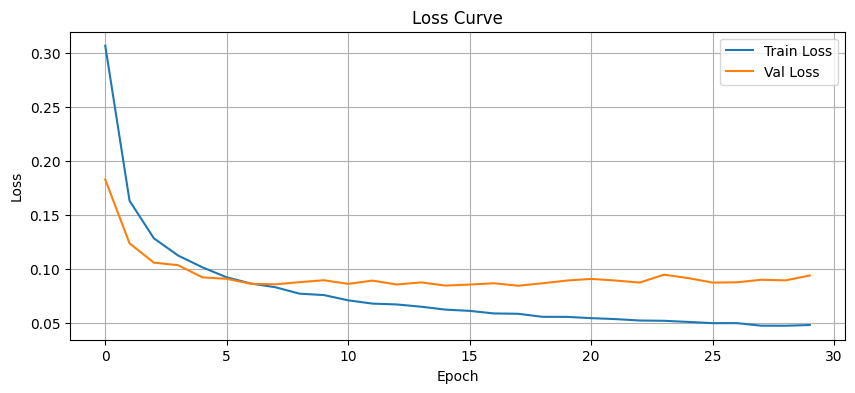

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# efficientnet-b3_unet_best_2.pth

In [ ]:
class PotholeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))

        mask = (mask > 0).astype(np.float32)  # Convert to binary

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)  # Add channel dim

        return image, mask


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [ ]:
data_root = 'dataset'

train_img_dir = os.path.join(data_root, 'train', 'images')
train_mask_dir = os.path.join(data_root, 'train', 'masks')

val_img_dir = os.path.join(data_root, 'val', 'images')
val_mask_dir = os.path.join(data_root, 'val', 'masks')

test_img_dir = os.path.join(data_root, 'test', 'images')
test_mask_dir = os.path.join(data_root, 'test', 'masks')

train_dataset = PotholeDataset(train_img_dir, train_mask_dir, transform=train_transform)
val_dataset = PotholeDataset(val_img_dir, val_mask_dir, transform=val_test_transform)
test_dataset = PotholeDataset(test_img_dir, test_mask_dir, transform=val_test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = smp.Unet("efficientnet-b3", encoder_weights="imagenet", in_channels=3, classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.amp.GradScaler('cuda')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


In [ ]:
def train_one_epoch(loader):
    model.train()
    epoch_loss = 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast('cuda', enabled=True):
            outputs = model(images)
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def validate(loader):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

In [ ]:
train_losses = []
val_losses = []

num_epochs = 30
best_val_loss = float('inf')  # initialize with very large value

for epoch in range(num_epochs):
    train_loss = train_one_epoch(train_loader)
    val_loss = validate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    scheduler.step(val_loss)

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "efficientnet-b3_unet_best_2.pth")
        print(f"✅ Saved best model at epoch {epoch+1} with val loss: {val_loss:.4f}")

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 1/30 | Train Loss: 0.2002 | Val Loss: 0.1243
✅ Saved best model at epoch 1 with val loss: 0.1243


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 2/30 | Train Loss: 0.1257 | Val Loss: 0.0994
✅ Saved best model at epoch 2 with val loss: 0.0994


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 3/30 | Train Loss: 0.1069 | Val Loss: 0.0921
✅ Saved best model at epoch 3 with val loss: 0.0921


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 4/30 | Train Loss: 0.0932 | Val Loss: 0.0859
✅ Saved best model at epoch 4 with val loss: 0.0859


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 5/30 | Train Loss: 0.0836 | Val Loss: 0.0884


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 6/30 | Train Loss: 0.0806 | Val Loss: 0.0835
✅ Saved best model at epoch 6 with val loss: 0.0835


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 7/30 | Train Loss: 0.0746 | Val Loss: 0.0885


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 8/30 | Train Loss: 0.0692 | Val Loss: 0.0845


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 9/30 | Train Loss: 0.0660 | Val Loss: 0.0864


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 10/30 | Train Loss: 0.0638 | Val Loss: 0.0847


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 11/30 | Train Loss: 0.0575 | Val Loss: 0.0840


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 12/30 | Train Loss: 0.0552 | Val Loss: 0.0829
✅ Saved best model at epoch 12 with val loss: 0.0829


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 13/30 | Train Loss: 0.0534 | Val Loss: 0.0863


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 14/30 | Train Loss: 0.0519 | Val Loss: 0.0865


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 15/30 | Train Loss: 0.0512 | Val Loss: 0.0894


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 16/30 | Train Loss: 0.0505 | Val Loss: 0.0869


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 17/30 | Train Loss: 0.0473 | Val Loss: 0.0852


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 18/30 | Train Loss: 0.0477 | Val Loss: 0.0926


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 19/30 | Train Loss: 0.0468 | Val Loss: 0.0871


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 20/30 | Train Loss: 0.0462 | Val Loss: 0.0878


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 21/30 | Train Loss: 0.0447 | Val Loss: 0.0893


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 22/30 | Train Loss: 0.0442 | Val Loss: 0.0872


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 23/30 | Train Loss: 0.0438 | Val Loss: 0.0890


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 24/30 | Train Loss: 0.0432 | Val Loss: 0.0882


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 25/30 | Train Loss: 0.0428 | Val Loss: 0.0889


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 26/30 | Train Loss: 0.0428 | Val Loss: 0.0891


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 27/30 | Train Loss: 0.0426 | Val Loss: 0.0893


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 28/30 | Train Loss: 0.0423 | Val Loss: 0.0904


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 29/30 | Train Loss: 0.0417 | Val Loss: 0.0892


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch 30/30 | Train Loss: 0.0411 | Val Loss: 0.0904


In [ ]:
model.load_state_dict(torch.load("efficientnet-b3_unet_best_2.pth"))
model.eval()

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Ident

In [ ]:
all_preds, all_targets = [], []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        outputs = torch.sigmoid(model(images)).cpu().squeeze().numpy()
        outputs = (outputs>0.3).astype(np.uint8)
        targets = masks.squeeze().numpy().astype(np.uint8)

        all_preds.append(outputs.flatten())
        all_targets.append(targets.flatten())

# Convert to arrays
y_true = np.concatenate(all_targets)
y_pred = np.concatenate(all_preds)

print("IoU:", jaccard_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))


IoU: 0.7502657222029017
Precision: 0.8248108480874964
Recall: 0.8924890543813526
F1 Score: 0.8573163636646095


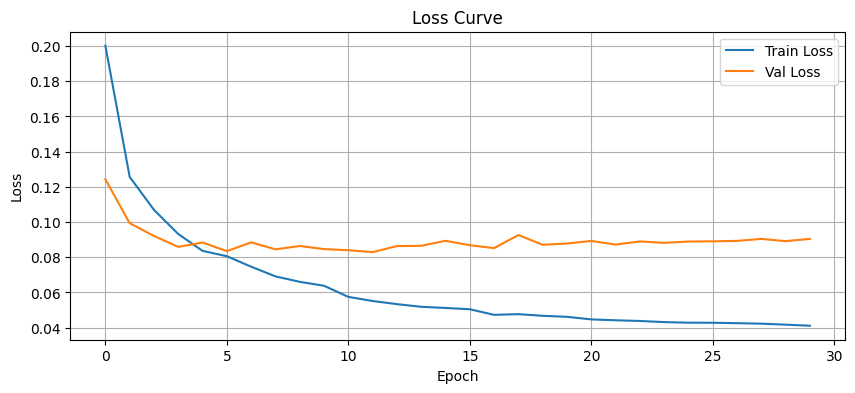

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Final Model

In [ ]:
class PotholeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))

        mask = (mask > 0).astype(np.float32)  # Convert to binary

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)  # Add channel dim

        return image, mask


In [ ]:
#Std, mean obtained during EDA
#Channel-wise Mean: [np.float64(0.4998810830269597), np.float64(0.48653796702665425), np.float64(0.471917316559437)]
#Channel-wise Std Dev: [np.float64(0.21051710513052657), np.float64(0.2076896831788104), np.float64(0.2159267077070667)]

train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=(0.500, 0.486, 0.472),
                std=(0.210, 0.208, 0.216)),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.500, 0.486, 0.472),
                std=(0.210, 0.208, 0.216)),
    ToTensorV2()
])


In [ ]:
data_root = 'dataset'

train_img_dir = os.path.join(data_root, 'train', 'images')
train_mask_dir = os.path.join(data_root, 'train', 'masks')

val_img_dir = os.path.join(data_root, 'val', 'images')
val_mask_dir = os.path.join(data_root, 'val', 'masks')

test_img_dir = os.path.join(data_root, 'test', 'images')
test_mask_dir = os.path.join(data_root, 'test', 'masks')

train_dataset = PotholeDataset(train_img_dir, train_mask_dir, transform=train_transform)
val_dataset = PotholeDataset(val_img_dir, val_mask_dir, transform=val_test_transform)
test_dataset = PotholeDataset(test_img_dir, test_mask_dir, transform=val_test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

class ComboLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice = DiceLoss()
        self.bce = nn.BCEWithLogitsLoss()
    def forward(self, inputs, targets):
        return self.bce(inputs, targets) + self.dice(inputs, targets)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    decoder_dropout=0.2
).to(device)

criterion = ComboLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
scaler = torch.cuda.amp.GradScaler()

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


In [ ]:
def train_one_epoch(loader):
    model.train()
    epoch_loss = 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def validate(loader):
    model.eval()
    val_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float().cpu().numpy().reshape(-1)
            targets = masks.cpu().numpy().reshape(-1)
            all_preds.extend(preds)
            all_targets.extend(targets)

    iou = jaccard_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    return val_loss / len(loader), iou, precision, recall, f1

In [ ]:
train_losses = []
val_losses = []
best_f1 = 0
epochs_no_improve = 0
patience = 5
num_epochs = 30
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_one_epoch(train_loader)
    val_loss, iou, precision, recall, f1 = validate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    scheduler.step(val_loss)

    # Save the best model
    if f1 > best_f1:
        best_f1 = f1
        epochs_no_improve = 0
        torch.save(model.state_dict(), "efficientnet-b3_unet_best_3.pth")
        print(f"✅ Best model saved at epoch {epoch+1} with F1: {f1:.4f}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("⏹ Early stopping triggered.")
            break

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 1/30 | Train Loss: 1.1765 | Val Loss: 0.7265
✅ Best model saved at epoch 1 with F1: 0.7946


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 2/30 | Train Loss: 0.5893 | Val Loss: 0.4369
✅ Best model saved at epoch 2 with F1: 0.8224


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 3/30 | Train Loss: 0.4187 | Val Loss: 0.3634
✅ Best model saved at epoch 3 with F1: 0.8281


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 4/30 | Train Loss: 0.3502 | Val Loss: 0.3221
✅ Best model saved at epoch 4 with F1: 0.8450


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 5/30 | Train Loss: 0.3094 | Val Loss: 0.3062
✅ Best model saved at epoch 5 with F1: 0.8456


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 6/30 | Train Loss: 0.2852 | Val Loss: 0.3095


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 7/30 | Train Loss: 0.2611 | Val Loss: 0.2858
✅ Best model saved at epoch 7 with F1: 0.8522


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 8/30 | Train Loss: 0.2474 | Val Loss: 0.2928


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 9/30 | Train Loss: 0.2376 | Val Loss: 0.2862


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 10/30 | Train Loss: 0.2355 | Val Loss: 0.2853
✅ Best model saved at epoch 10 with F1: 0.8554


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 11/30 | Train Loss: 0.2227 | Val Loss: 0.2709
✅ Best model saved at epoch 11 with F1: 0.8596


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 12/30 | Train Loss: 0.2110 | Val Loss: 0.2813


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 13/30 | Train Loss: 0.2033 | Val Loss: 0.2935


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 14/30 | Train Loss: 0.2000 | Val Loss: 0.2840


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 15/30 | Train Loss: 0.1925 | Val Loss: 0.2816


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 16/30 | Train Loss: 0.1822 | Val Loss: 0.2870
⏹ Early stopping triggered.


In [ ]:
model.load_state_dict(torch.load("efficientnet-b3_unet_best_3.pth"))
model.eval()

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding

In [ ]:
all_preds, all_targets = [], []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        outputs = torch.sigmoid(model(images)).cpu().squeeze().numpy()
        outputs = (outputs>0.5).astype(np.uint8)
        targets = masks.squeeze().numpy().astype(np.uint8)

        all_preds.append(outputs.flatten())
        all_targets.append(targets.flatten())

# Convert to arrays
y_true = np.concatenate(all_targets)
y_pred = np.concatenate(all_preds)

print("IoU:", jaccard_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))

IoU:  0.8332227426198847
Precision: 0.8971891948775699
Recall: 0.931359969037675
F1 Score: 0.9160802233780621


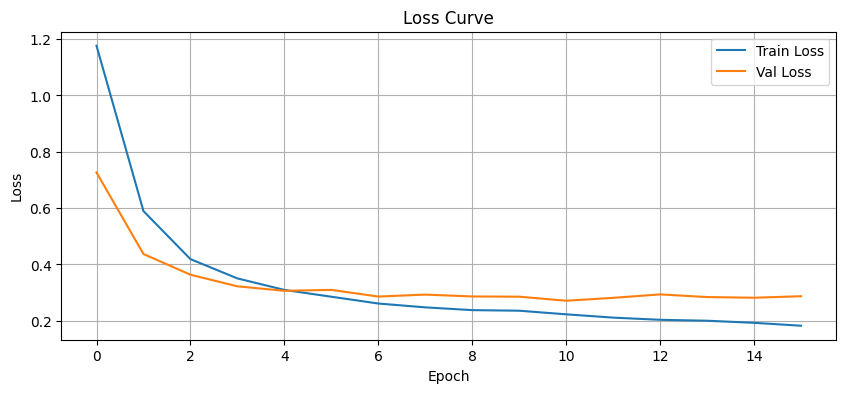

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Test Dataset Predictions Visualisations

In [ ]:
import random

def visualize_prediction(model, loader, num_images=5):
    model.eval()
    all_images = []
    all_masks = []

    # Collect all images and masks from the loader
    with torch.no_grad():
        for images, masks in loader:
            for i in range(images.size(0)):
                all_images.append(images[i])
                all_masks.append(masks[i])

    # Randomly sample indices
    sample_indices = random.sample(range(len(all_images)), min(num_images, len(all_images)))

    for idx in sample_indices:
        image = all_images[idx].unsqueeze(0).to(device)
        mask = all_masks[idx]

        with torch.no_grad():
            output = model(image)
            pred = torch.sigmoid(output)
            pred = (pred > 0.5).float()

        image_np = image[0].cpu().permute(1, 2, 0).numpy()
        image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        image_np = (image_np * 255).astype("uint8")

        pred_mask = pred[0][0].cpu().numpy()
        gt_mask = mask[0].cpu().numpy()

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(image_np)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Ground Truth Mask")
        plt.imshow(gt_mask, cmap='gray')
        plt.axis("off")

        plt.tight_layout()
        plt.show()


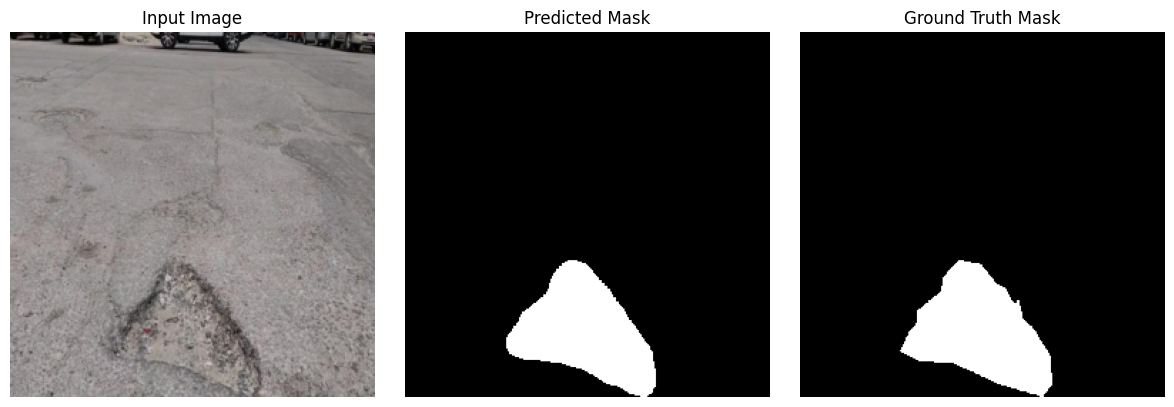

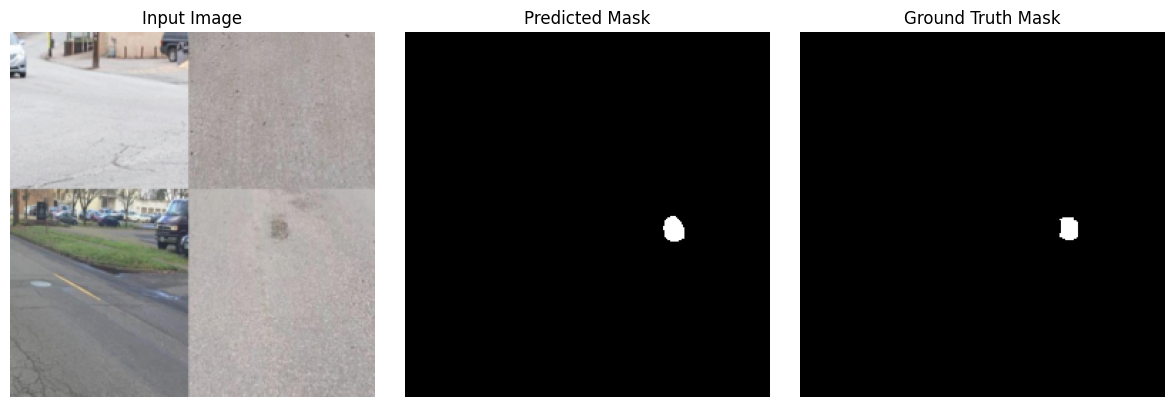

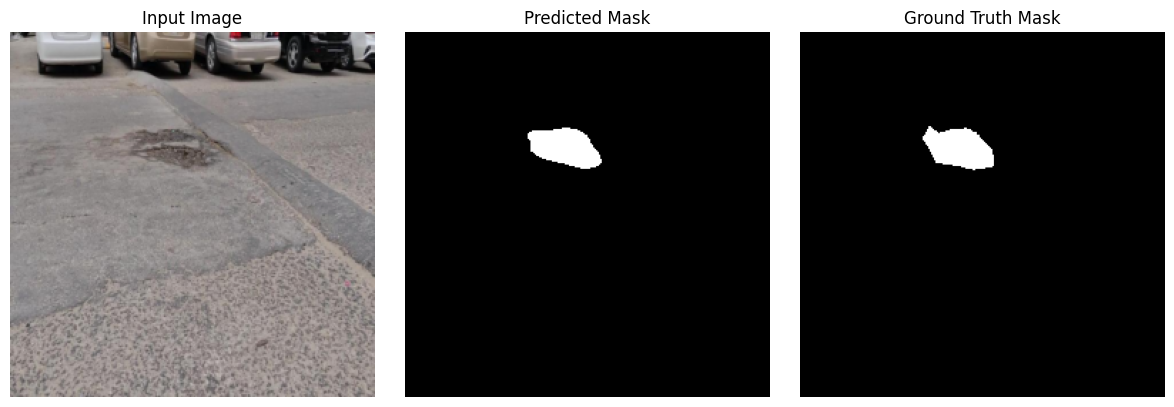

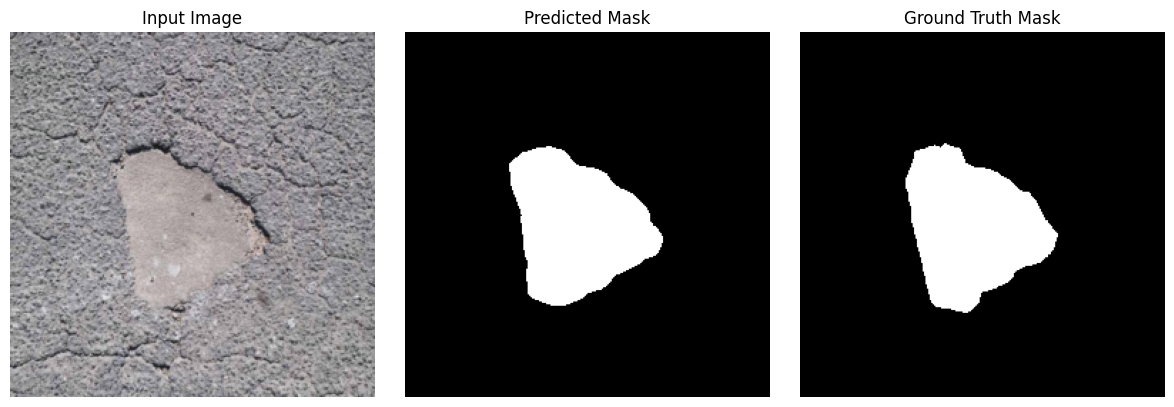

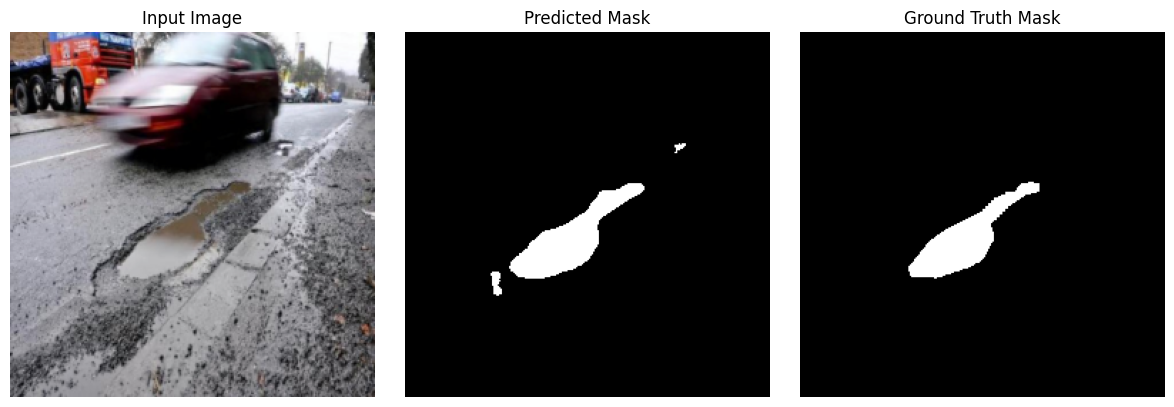

In [ ]:
visualize_prediction(model, test_loader, num_images=5)


# Uploaded Image and Video Inference

Image Inference

In [4]:
!pip install segmentation_models_pytorch
import torch
import segmentation_models_pytorch as smp



In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

def predict_image(image_path, model, transform, device):
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    augmented = transform(image=image_np)
    input_tensor = augmented['image'].unsqueeze(0).to(device)  # Add batch dim

    # Inference
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()
        binary_mask = (pred_mask > 0.5).astype(np.uint8)

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask (Raw)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(binary_mask, cmap='gray')
    plt.title('Predicted Mask (Binary)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return binary_mask


val_test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [5]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-initialize the model
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b3",
    encoder_weights=None,         # No pretrained weights
    in_channels=3,
    classes=1,
    decoder_dropout=0.2
).to(device)

# Load trained weights
model.load_state_dict(torch.load("efficientnet-b3_unet_best_3.pth", map_location=device))

<All keys matched successfully>

Saving download (5).jpeg to download (5) (3).jpeg


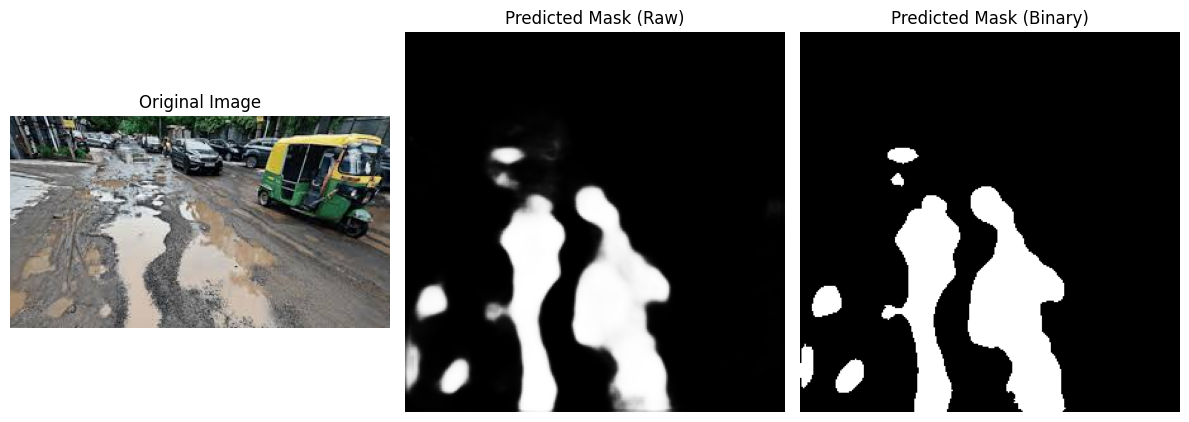

In [7]:
# Step 1: Upload video
from google.colab import files
uploaded = files.upload()

import os
user_image_path = next(iter(uploaded))

# Predict and visualize
predicted_mask = predict_image(
    image_path=user_image_path,
    model=model,
    transform=val_test_transform,
    device=device
)

Video Inference

In [15]:

import cv2
from google.colab import files
import tempfile
from tqdm import tqdm

def predict_video_overlay(video_path, model, transform, device, output_path='overlay_output.avi'):
    import cv2
    import numpy as np
    from tqdm import tqdm

    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Define video writer for output
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    model.eval()
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    pbar = tqdm(total=total_frames, desc="Processing frames with overlay")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Apply transform
        augmented = transform(image=rgb_frame)
        input_tensor = augmented['image'].unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()
            binary_mask = (pred_mask > 0.5).astype(np.uint8) * 255

        # Resize mask back to original frame size
        binary_mask_resized = cv2.resize(binary_mask, (frame_width, frame_height))

        # Convert to 3-channel color mask (e.g., red overlay)
        mask_color = np.zeros_like(frame)
        mask_color[:, :, 2] = binary_mask_resized  # Red channel

        # Overlay mask on original frame
        overlayed = cv2.addWeighted(frame, 1.0, mask_color, 0.5, 0)

        out.write(overlayed)
        pbar.update(1)

    cap.release()
    out.release()
    pbar.close()
    print(f"✅ Overlay video saved at: {output_path}")


def convert_avi_to_mp4(input_path='pothole_prediction_output.avi', output_path='pothole_prediction_output.mp4'):
    # Read the input .avi video
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("❌ Error opening AVI file")
        return

    # Get properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the mp4 codec and writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' is widely supported
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)

    cap.release()
    out.release()
    print(f"✅ Conversion complete: {output_path}")



In [20]:
# Upload video file
uploaded_video = files.upload()
video_path = next(iter(uploaded_video))

# Run prediction
predict_video_overlay(
    video_path=video_path,
    model=model,
    transform=val_test_transform,
    device=device,
    output_path='overlay_output.avi'
)

convert_avi_to_mp4('overlay_output.avi', 'pothole_prediction_output.mp4')

Saving sample_video.mp4 to sample_video (2).mp4


Processing frames with overlay: 100%|██████████| 375/375 [00:16<00:00, 22.51it/s]


✅ Overlay video saved at: overlay_output.avi
✅ Conversion complete: pothole_prediction_output.mp4
